In [124]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2.functional import to_pil_image
from torch.nn import SmoothL1Loss, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import json
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
import sys
sys.path.append("drive/MyDrive/SSD/")

from utils import transform_cwh_to_xyxy
from feature_extractor import SSDFeatureExtractor, ConvBlock
from generate_ground_truth import GenerateGroundTruth

In [4]:
def plot_images(images, bboxes=None, labels=None, class_names=None, figsize=(10, 10)):
    # Generated by ChatGPT.

    # Ensure images is a list for batch processing
    if isinstance(images, torch.Tensor):
        images = [images] if images.dim() == 3 else list(images)

    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for i, (img, ax) in enumerate(zip(images, axes)):
        # Convert tensor to numpy and move to range [0, 1]
        img = to_pil_image(img)  # Convert (C, H, W) to PIL
        ax.imshow(img)

        # Draw bounding boxes if provided
        if bboxes is not None and bboxes[i] is not None:
            for j, box in enumerate(bboxes[i]):
                x_min, y_min, x_max, y_max = box
                width, height = x_max - x_min, y_max - y_min

                # Create a rectangle
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='b', facecolor='none')
                ax.add_patch(rect)

                # Add label text if provided
                if labels is not None and class_names is not None:
                    label_idx = int(labels[i][j])  # Convert tensor to integer index
                    ax.text(x_min, y_min - 5, class_names[label_idx], color='white',
                            bbox=dict(facecolor='blue', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

        ax.axis("off")  # Hide axes

    plt.show()

In [ ]:
extractor = SSDFeatureExtractor().to("cuda")

In [ ]:
batch = torch.rand((64, 3, 300, 300), device="cuda")

In [ ]:
maps = extractor(batch)

In [ ]:
for map in maps.values():
    print(map.shape)

torch.Size([64, 512, 38, 38])
torch.Size([64, 1024, 19, 19])
torch.Size([64, 512, 10, 10])
torch.Size([64, 256, 5, 5])
torch.Size([64, 256, 3, 3])
torch.Size([64, 256, 1, 1])


In [ ]:
# Input: (B, 512, 38, 38), Expected output: (B, 4, 38, 38) for offsets
det_head1 = nn.Conv2d(in_channels=512, out_channels=4*4,  kernel_size=1).to("cuda")
det_head1(maps["conv4_3"]).shape

torch.Size([64, 16, 38, 38])

In [ ]:
cls_head1 = nn.Conv2d(in_channels=512, out_channels=21, kernel_size=1).to("cuda")
cls_head1(maps["conv4_3"]).shape

torch.Size([64, 21, 38, 38])

In [ ]:
det_head = lambda in_c: nn.Conv2d(in_channels=in_c, out_channels=4, kernel_size=1).to("cuda")

In [ ]:
for map in maps.values():
    print(det_head(map.shape[1])(map).shape)

torch.Size([64, 4, 38, 38])
torch.Size([64, 4, 19, 19])
torch.Size([64, 4, 10, 10])
torch.Size([64, 4, 5, 5])
torch.Size([64, 4, 3, 3])
torch.Size([64, 4, 1, 1])


In [5]:
in_channels_per_map = [512, 1024, 512, 256, 256, 256]
in_channels_per_map

[512, 1024, 512, 256, 256, 256]

In [6]:
n_classes = 21
n_dbox_per_map = [4, 6, 6, 6, 4, 4]

In [7]:
class SSDDetectionHead(nn.Module):
    """Defines the conv layers responsible for predicting box offsets and class scores."""

    def __init__(self, in_channels_per_map, n_dbox_per_map, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.reg_heads = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels_per_map[i], out_channels=4*n_dbox_per_map[i], kernel_size=1)
            for i in range(len(in_channels_per_map))])

        self.cls_heads = nn.ModuleList(
            [nn.Conv2d(in_channels=in_channels_per_map[i], out_channels=n_classes*n_dbox_per_map[i], kernel_size=1)
            for i in range(len(in_channels_per_map))])

        for reg_head, cls_head in zip(self.reg_heads, self.cls_heads):
            nn.init.xavier_uniform_(reg_head.weight)
            nn.init.xavier_uniform_(cls_head.weight)

            nn.init.zeros_(reg_head.bias)
            nn.init.zeros_(cls_head.bias)

    def forward(self, maps):
        """Takes in feature maps extracted from base model and predicts offsets and class scores of the default boxes.
        Output dim: ((B, 8732, 4), (B, 8732, n_classes))"""

        batch_size = next(iter(maps)).shape[0]

        det_outputs = torch.cat([reg_head(map).view(batch_size, -1, 4)
                        for map, reg_head in zip(maps, self.reg_heads)], dim=1)

        cls_outputs = torch.cat([cls_head(map).view(batch_size, -1, self.n_classes)
                        for map, cls_head in zip(maps, self.cls_heads)], dim=1)

        return det_outputs, cls_outputs

In [ ]:
ssd_predictor = SSDDetectionHead(in_channels_per_map, n_dbox_per_map, n_classes).to("cuda")

In [ ]:
out = ssd_predictor(maps.values())

In [ ]:
out[0].shape, out[1].shape

(torch.Size([64, 8732, 4]), torch.Size([64, 8732, 21]))

#Data Loading

In [8]:
all_classes = [
    "bg", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

In [9]:
labels_to_idx = {y:x for x, y in list(enumerate(all_classes))}

In [10]:
path = Path("drive/MyDrive/Datasets/voc0712/VOC_dataset/VOCdevkit")
path07 = path/"VOC2007"
path12 = path/"VOC2012"

In [11]:
with open(path12/"voc12_trainval.json") as file:
    data12 = json.load(file)

In [12]:
with open(path07/"voc07_trainval.json") as file:
    data07 = json.load(file)

In [13]:
import random
random.seed(69)

def split_data(data, val_percent=0.1):
    random.shuffle(data)
    val_size = int(len(data)*val_percent)
    return data[val_size:], data[:val_size]

In [14]:
train12, val12 = split_data(data12)
train07, val07 = split_data(data07)

In [15]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomChoice([
        v2.Identity(),
        v2.RandomResizedCrop(size=(300, 300),
                             scale=(0.1, 1),
                             ratio=(0.5,2)),
        v2.RandomIoUCrop(min_scale=0.1, max_scale=1,
                         min_aspect_ratio=0.5, max_aspect_ratio=2,
                         sampler_options=[0.1, 0.3, 0.5, 0.7, 0.9],
                         trials=50),
    ]),
    v2.Resize((300, 300)),
    v2.SanitizeBoundingBoxes(labels_getter=None),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    GenerateGroundTruth(device="cpu")
])

In [16]:
class VOCDataset(Dataset):
    def __init__(self, data, img_path, transforms, labels_to_idx):
        self.data = data
        self.img_path = img_path
        self.transforms = transforms
        self.labels_to_idx = labels_to_idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        annotation = self.data[index]

        img = Image.open(self.img_path/annotation["filename"]).convert("RGB")
        bbox_t = tv_tensors.BoundingBoxes(annotation["bbox"], format="XYXY",
                                          canvas_size=img.size[::-1])
        labels_t = torch.tensor([self.labels_to_idx[k] for k in annotation["class"]],
                                dtype=torch.long)

        transformed = self.transforms(img, bbox_t, labels_t)
        assert len(transformed) == 3, f"length: {len(transformed)} for item {index}"

        return transformed[0], transformed[1:]

In [17]:
train_ds12 = VOCDataset(train12, path12/"JPEGImages", transforms, labels_to_idx)
train_ds07 = VOCDataset(train07, path07/"JPEGImages", transforms, labels_to_idx)

In [18]:
val_ds12 = VOCDataset(val12, path12/"JPEGImages", transforms, labels_to_idx)
val_ds07 = VOCDataset(val07, path07/"JPEGImages", transforms, labels_to_idx)

In [19]:
train_ds = ConcatDataset([train_ds12, train_ds07])
val_ds = ConcatDataset([val_ds12, val_ds07])

In [20]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True, num_workers=0, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True, num_workers=0)

#Loss Function

In [21]:
x, y = next(iter(train_dl))

In [22]:
x.shape, y[0].shape, y[1].shape

(torch.Size([32, 3, 300, 300]),
 torch.Size([32, 8732, 4]),
 torch.Size([32, 8732]))

In [23]:
x = x.to("cuda")

In [24]:
len(train_dl)

465

In [25]:
gt_bboxes, gt_labels = y[0].to("cuda"), y[1].to("cuda")

In [26]:
extractor = SSDFeatureExtractor().to("cuda")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 173MB/s]


In [27]:
maps = extractor(x.to("cuda"))

In [28]:
for m in maps.values(): print(m.shape)

torch.Size([32, 512, 38, 38])
torch.Size([32, 1024, 19, 19])
torch.Size([32, 512, 10, 10])
torch.Size([32, 256, 5, 5])
torch.Size([32, 256, 3, 3])
torch.Size([32, 256, 1, 1])


In [29]:
det_head = SSDDetectionHead(in_channels_per_map, n_dbox_per_map, n_classes).to("cuda")

In [30]:
preds = det_head(maps.values())

In [31]:
preds[0].shape, preds[1].shape

(torch.Size([32, 8732, 4]), torch.Size([32, 8732, 21]))

In [32]:
pred_bboxes, pred_labels = preds

In [ ]:
l1_loss = SmoothL1Loss()
cross_entropy = CrossEntropyLoss()

In [ ]:
# Loss function is computed for each image individually.

In [ ]:
img1, gt_bboxes1, gt_labels1 = x[0], gt_bboxes[0], gt_labels[0]
img1.shape, gt_bboxes1.shape, gt_labels1.shape

(torch.Size([3, 300, 300]), torch.Size([8732, 4]), torch.Size([8732]))

In [ ]:
pred_bboxes1, pred_labels1 = pred_bboxes[0], pred_labels[0]
pred_bboxes1.shape, pred_labels1.shape

(torch.Size([8732, 4]), torch.Size([8732, 21]))

In [ ]:
# L1 Loss
l1_loss(pred_bboxes1, gt_bboxes1)

In [ ]:
# Cross Entropy:

In [ ]:
positive_mask = gt_labels1 != 0
negative_mask = ~positive_mask
positive_mask.shape

torch.Size([8732])

In [ ]:
n_matched_dboxes = positive_mask.sum()
n_matched_dboxes

tensor(8, device='cuda:0')

In [ ]:
negative_box_scores = pred_labels1[negative_mask]
negative_box_scores.shape

torch.Size([8724, 21])

In [ ]:
negative_box_indices = torch.nonzero(negative_mask).flatten()
negative_box_indices

tensor([   0,    1,    2,  ..., 8725, 8726, 8727], device='cuda:0')

In [ ]:
class_probs = F.softmax(negative_box_scores, dim=-1)
class_probs.shape

torch.Size([8724, 21])

In [ ]:
misclassified_negative_mask = torch.max(class_probs, dim=-1)[1] != 0
misclassified_negative_mask.sum()

tensor(8208, device='cuda:0')

In [ ]:
misclassified_probs = class_probs[misclassified_negative_mask]
misclassified_probs.shape

torch.Size([8208, 21])

In [ ]:
misclassified_negative_indices = torch.nonzero(misclassified_negative_mask).squeeze()
misclassified_negative_indices

tensor([   1,    3,    4,  ..., 8721, 8722, 8723], device='cuda:0')

In [ ]:
class_probs.shape[0]-misclassified_probs.shape[0]

516

In [ ]:
hard_negative_idxs = misclassified_probs[:, 0].sort()[1][:3*n_matched_dboxes]
hard_negative_idxs

tensor([4195, 3425, 1111, 2074, 1802, 1587, 2743,  158,  393, 1694,  749, 1727,
        5140, 2111, 1476, 3026, 4235, 2785, 1649,  265,  469,  834, 1102, 2942],
       device='cuda:0')

In [ ]:
pred_labels1[positive_mask].shape, pred_labels1[hard_negative_idxs].shape

(torch.Size([8, 21]), torch.Size([24, 21]))

In [ ]:
gt_labels1[positive_mask].shape, gt_labels1[hard_negative_idxs].shape

(torch.Size([8]), torch.Size([24]))

In [ ]:
gt_labels_final = torch.cat((gt_labels1[positive_mask], gt_labels1[hard_negative_idxs]), dim=0)
gt_labels_final.shape

torch.Size([32])

In [ ]:
pred_labels_final = torch.cat((pred_labels1[positive_mask], pred_labels1[hard_negative_idxs]), dim=0)
pred_labels_final.shape

torch.Size([32, 21])

In [ ]:
cross_entropy(pred_labels_final, gt_labels_final)

tensor(3.3764, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
# Positive: Default boxes that match some object.
# Negative: Default boxes that don't match any object, so they are bg.

In [ ]:
def get_hard_negatives(pred_scores, positive_box_mask):
    """
    Returns indices of hard negatives.
    Input:
        pred_scores: (B, 8732, n_classes)
        positive_box_mask: (B, 8732)
    Output:
        hard_negative_idxs: (B, 3*n_positives)
    """

    n_positives = positive_box_mask.sum()
    negative_box_scores = pred_scores[~positive_box_mask]

    class_probs = F.softmax(negative_box_scores, dim=-1)
    misclassified_negative_mask = torch.max(class_probs, dim=1)[1] != 0

    misclassified_probs = class_probs[misclassified_negative_mask]

    hard_negative_idxs = misclassified_probs[:, 0].sort()[1][:3*n_positives]

    return hard_negative_idxs

In [ ]:
nn.L1Loss(reduction="mean")(pred_bboxes, gt_bboxes)

tensor(0.7485, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
l1_loss_per_image = nn.L1Loss(reduction="none")(pred_bboxes, gt_bboxes).mean(dim=1)
l1_loss_per_image.mean()

tensor(0.7485, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
pos_mask = gt_labels != 0
pos_mask.shape

torch.Size([64, 8732])

In [ ]:
n_pos = pos_mask.sum(dim=1)
n_neg = 8732 - n_pos
n_neg

tensor([8725, 8724, 8732, 8711, 8720, 8680, 8712, 8719, 8681, 8671, 8698, 8680,
        8695, 8732, 8633, 8705, 8718, 8716, 8725, 8706, 8718, 8713, 8723, 8660,
        8720, 8700, 8718, 8716, 8724, 8724, 8653, 8719, 8722, 8720, 8641, 8697,
        8724, 8579, 8727, 8719, 8665, 8724, 8701, 8710, 8694, 8719, 8640, 8719,
        8688, 8711, 8609, 8722, 8682, 8596, 8715, 8731, 8688, 8710, 8714, 8717,
        8718, 8717, 8620, 8711], device='cuda:0')

In [ ]:
pred_labels[0][~pos_mask[0]].shape

torch.Size([8725, 21])

In [ ]:
[i.shape for i in pred_labels[~pos_mask].split(tuple(n_neg))]

In [ ]:
all_neg_scores = pred_labels[~pos_mask]
all_neg_scores.shape

torch.Size([556721, 21])

In [ ]:
neg_probs = all_neg_scores.softmax(dim=-1)
neg_probs[0].sum(), neg_probs.shape

(tensor(1., device='cuda:0', grad_fn=<SumBackward0>), torch.Size([556721, 21]))

In [ ]:
misclassified_neg_mask = neg_probs.max(dim=-1)[1] != 0
misclassified_neg_mask.shape

torch.Size([556721])

In [ ]:
misclassified_neg_probs = neg_probs[misclassified_neg_mask]
misclassified_neg_probs.shape

torch.Size([522840, 21])

In [ ]:
sum([i.sum() for i in misclassified_neg_mask.split(tuple(n_neg))])

tensor(522840, device='cuda:0')

#Loss Function take 2

In [33]:
def get_hard_negatives(pred_scores, positive_box_mask, n_positives):
    """
    Returns indices of hard negatives.
    Input:
        pred_scores: (8732, n_classes)
        positive_box_mask: (8732)
    Output:
        hard_negative_idxs: (3*n_positives)
    """

    negative_mask = ~positive_box_mask
    negative_indices = torch.nonzero(negative_mask).flatten()

    negative_box_scores = pred_scores[negative_mask]

    class_probs = F.softmax(negative_box_scores, dim=-1)

    misclassified_negative_mask = torch.max(class_probs, dim=1)[1] != 0
    misclassified_probs = class_probs[misclassified_negative_mask]
    misclassified_indices = torch.nonzero(misclassified_negative_mask).flatten()

    hard_negative_idxs = misclassified_probs[:, 0].sort()[1][:3*n_positives]

    # After finding hard negatives in misclassfied probabilites, the indices need to be mapped to the original data
    final_idxs = negative_indices[misclassified_indices[hard_negative_idxs]]

    return final_idxs

In [34]:
pred_scores = pred_labels
pred_bboxes.shape, pred_scores.shape

(torch.Size([32, 8732, 4]), torch.Size([32, 8732, 21]))

In [35]:
gt_bboxes.shape, gt_labels.shape

(torch.Size([32, 8732, 4]), torch.Size([32, 8732]))

In [36]:
batch_size = pred_scores.shape[0]
batch_size

32

In [37]:
smooth_l1_loss = nn.SmoothL1Loss(reduction="none")
cross_entropy = nn.CrossEntropyLoss()

In [38]:
nn.SmoothL1Loss()(gt_bboxes, pred_bboxes)

tensor(0.4057, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [39]:
pos_mask = gt_labels != 0
pos_mask.shape

torch.Size([32, 8732])

In [40]:
n_pos = pos_mask.sum(dim=-1)
n_pos

tensor([  7,  19,  35,  40,  52,  16,  67,  39,  46,   7,  31,  41,  18,   8,
          7,  30,  13,   8,  84,   9,  27, 129,  34,  72,  47,  22,  15,  35,
        115,   8,  21,  62], device='cuda:0')

In [41]:
l1_loss_per_image = smooth_l1_loss(pred_bboxes, gt_bboxes).mean(dim=(1, 2))
l1_loss_per_image

tensor([0.4119, 0.3876, 0.3936, 0.4431, 0.4005, 0.3979, 0.4195, 0.3801, 0.4413,
        0.4155, 0.3936, 0.3863, 0.4212, 0.3659, 0.3926, 0.3729, 0.4018, 0.4130,
        0.3972, 0.3970, 0.4112, 0.4143, 0.4216, 0.3953, 0.4633, 0.3810, 0.4179,
        0.4217, 0.4115, 0.4018, 0.4110, 0.3981], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [42]:
cross_entropy_per_image = torch.zeros(batch_size, device="cuda")
cross_entropy_per_image.shape

torch.Size([32])

In [43]:
hn_idxs = get_hard_negatives(pred_scores[0], pos_mask[0], n_pos[0])
hn_idxs

tensor([ 605,  509, 5380, 3349, 1207, 1953, 2512,  531, 5396, 2483, 5382, 4488,
        2789,  951, 5166,  132, 4691, 3691,  575, 5548, 5401], device='cuda:0')

In [44]:
gt_labels_final0 = torch.cat((gt_labels[0][pos_mask[0]], gt_labels[0][hn_idxs]))
gt_labels_final0.shape

torch.Size([28])

In [45]:
pred_scores_final0 = torch.cat((pred_scores[0][pos_mask[0]], pred_scores[0][hn_idxs]))
pred_scores_final0.shape

torch.Size([28, 21])

In [46]:
cross_entropy(pred_scores_final0, gt_labels_final0)

tensor(6.1582, device='cuda:0', grad_fn=<NllLossBackward0>)

In [47]:
cross_entropy_per_image = torch.zeros(batch_size, device="cuda")
for i in range(batch_size):
    hard_negative_idxs = get_hard_negatives(pred_scores[i], pos_mask[i], n_pos[i])
    gt_labels_final = torch.cat((gt_labels[i][pos_mask[i]],
                                 gt_labels[i][hard_negative_idxs]))
    pred_scores_final = torch.cat((pred_scores[i][pos_mask[i]],
                                   pred_scores[i][hard_negative_idxs]))
    cross_entropy_per_image[i] = cross_entropy(pred_scores_final, gt_labels_final)

In [48]:
l1_loss_per_image.shape, cross_entropy_per_image.shape, n_pos.shape

(torch.Size([32]), torch.Size([32]), torch.Size([32]))

In [49]:
loss_per_image = (l1_loss_per_image+cross_entropy_per_image)
loss_per_image

tensor([6.5701, 5.9973, 5.8840, 5.8298, 5.6785, 5.9246, 5.6082, 5.6335, 5.7463,
        6.2737, 5.8495, 5.7797, 5.9622, 6.2365, 6.4525, 5.8355, 6.0094, 6.2263,
        5.5266, 6.1295, 6.0252, 5.4488, 5.9700, 5.6409, 5.6754, 5.9227, 6.1307,
        5.7160, 5.2608, 6.3887, 6.1593, 5.5617], device='cuda:0',
       grad_fn=<AddBackward0>)

In [50]:
loss_per_image[n_pos==0] = 0
loss_per_image

tensor([6.5701, 5.9973, 5.8840, 5.8298, 5.6785, 5.9246, 5.6082, 5.6335, 5.7463,
        6.2737, 5.8495, 5.7797, 5.9622, 6.2365, 6.4525, 5.8355, 6.0094, 6.2263,
        5.5266, 6.1295, 6.0252, 5.4488, 5.9700, 5.6409, 5.6754, 5.9227, 6.1307,
        5.7160, 5.2608, 6.3887, 6.1593, 5.5617], device='cuda:0',
       grad_fn=<IndexPutBackward0>)

In [51]:
loss_per_image.mean()

tensor(5.9079, device='cuda:0', grad_fn=<MeanBackward0>)

In [52]:
class SSDLoss:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction="none")
        self.cross_entropy = nn.CrossEntropyLoss()

    def get_hard_negatives(self, pred_scores, positive_box_mask, n_positives):
        """
        Returns indices of hard negatives.
        Input:
            pred_scores: (8732, n_classes)
            positive_box_mask: (8732)
        Output:
            hard_negative_idxs: (3*n_positives)
        """
        with torch.no_grad():
            negative_mask = ~positive_box_mask
            negative_indices = torch.nonzero(negative_mask).flatten()

            negative_box_scores = pred_scores[negative_mask]

            class_probs = F.softmax(negative_box_scores, dim=-1)

            misclassified_negative_mask = torch.max(class_probs, dim=1)[1] != 0
            misclassified_probs = class_probs[misclassified_negative_mask]
            misclassified_indices = torch.nonzero(misclassified_negative_mask).flatten()

            hard_negative_idxs = misclassified_probs[:, 0].sort()[1][:3*n_positives]

            # After finding hard negatives in misclassfied probabilites, the indices need to be mapped to the original data
            final_idxs = negative_indices[misclassified_indices[hard_negative_idxs]]

        return final_idxs

    def __call__(self, preds, gt):
        gt_bboxes, gt_labels = gt
        pred_bboxes, pred_scores = preds

        batch_size = gt_bboxes.shape[0]

        positive_bbox_mask = gt_labels != 0
        n_positives_per_image = positive_bbox_mask.sum(dim=-1)

        # Smooth L1 Loss
        smooth_l1_per_image = self.smooth_l1_loss(pred_bboxes, gt_bboxes).mean(dim=(1, 2))

        # Cross Entropy Loss
        cross_entropy_per_image = torch.zeros(batch_size, device=gt_bboxes.device)
        for i in range(batch_size):
            if n_positives_per_image[i] == 0:
                continue

            hard_negative_idxs = self.get_hard_negatives(pred_scores[i], positive_bbox_mask[i], n_positives_per_image[i])

            gt_labels_final = torch.cat((gt_labels[i][positive_bbox_mask[i]],
                                        gt_labels[i][hard_negative_idxs]))

            pred_scores_final = torch.cat((pred_scores[i][positive_bbox_mask[i]],
                                        pred_scores[i][hard_negative_idxs]))

            cross_entropy_per_image[i] = self.cross_entropy(pred_scores_final, gt_labels_final)

        # Final Loss
        loss_per_image = (smooth_l1_per_image + self.alpha * cross_entropy_per_image)
        loss_per_image[n_positives_per_image==0] = 0

        return loss_per_image.mean()

In [53]:
ssd_loss = SSDLoss()

In [69]:
loss = ssd_loss(preds, (gt_bboxes, gt_labels))
loss

tensor(5.9079, device='cuda:0', grad_fn=<MeanBackward0>)

In [71]:
loss.backward()

In [73]:
for reg_head in det_head.reg_heads:
    print(reg_head.weight.grad.shape)

torch.Size([16, 512, 1, 1])
torch.Size([24, 1024, 1, 1])
torch.Size([24, 512, 1, 1])
torch.Size([24, 256, 1, 1])
torch.Size([16, 256, 1, 1])
torch.Size([16, 256, 1, 1])


In [75]:
for reg_head in det_head.cls_heads:
    print(reg_head.weight.grad.shape)

torch.Size([84, 512, 1, 1])
torch.Size([126, 1024, 1, 1])
torch.Size([126, 512, 1, 1])
torch.Size([126, 256, 1, 1])
torch.Size([84, 256, 1, 1])
torch.Size([84, 256, 1, 1])


In [77]:
extractor.scale_weight.grad.shape

torch.Size([1, 512, 1, 1])

In [81]:
for l in extractor.conv4_3:
    if isinstance(l, nn.Conv2d):
        print(l.weight.grad.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([128, 128, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([256, 256, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])


In [79]:
for l in extractor.conv7:
    if isinstance(l, nn.Conv2d):
        print(l.weight.grad.shape)

torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])
torch.Size([512, 512, 3, 3])


In [102]:
for l in extractor.extra:
    for s in l:
        print(s.conv.weight.grad.shape)

torch.Size([256, 1024, 1, 1])
torch.Size([512, 256, 3, 3])
torch.Size([128, 512, 1, 1])
torch.Size([256, 128, 3, 3])
torch.Size([128, 256, 1, 1])
torch.Size([256, 128, 3, 3])
torch.Size([128, 256, 1, 1])
torch.Size([256, 128, 3, 3])


In [123]:
extractor_parameters = list(extractor.parameters())
det_head_parameters = list(det_head.parameters())
parameters = extractor_parameters + det_head_parameters

In [128]:
optimizer = torch.optim.SGD(parameters, lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [129]:
optimizer.step()

In [133]:
maps = extractor(x.to("cuda"))

In [131]:
preds = det_head(maps.values())

In [132]:
loss = ssd_loss(preds, (gt_bboxes, gt_labels))
loss

tensor(5.9027, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
# Loss is better, Optimizer works

##Small Test

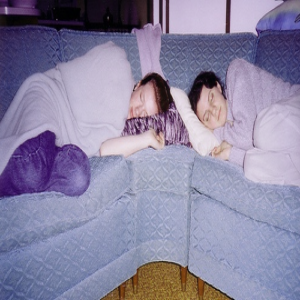

In [ ]:
to_pil_image(x[16])

In [ ]:
def decode_offsets(offsets, dboxes_cwh, transform=0):
    dcx, dcy, dw, dh = dboxes_cwh.T
    ocx, ocy, ow, oh = offsets.T
    cx = ocx*dw + dcx
    cy = ocy*dh + dcy
    w = torch.exp(ow)*dw
    h = torch.exp(oh)*dh
    res = torch.stack([cx,cy,w,h], dim=1)
    return transform_cwh_to_xyxy(res) if transform else res

In [ ]:
bb = decode_offsets(gt_bboxes[16], GenerateGroundTruth().dboxes.dboxes, transform=1)

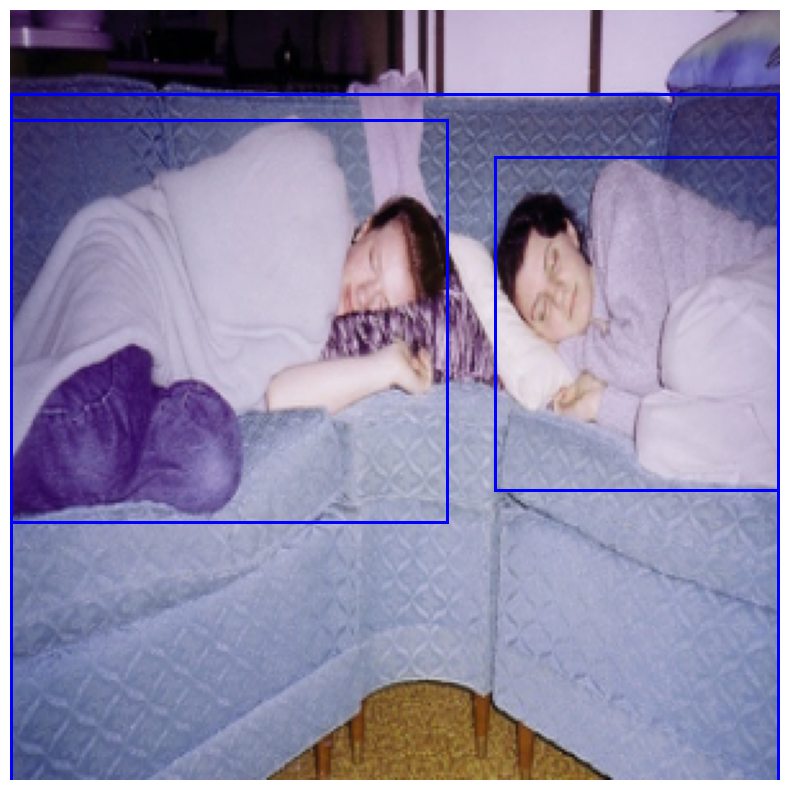

In [ ]:
plot_images(x[16], [(bb.cpu()*300)[gt_labels[16].cpu()!=0]])